<a href="https://colab.research.google.com/github/ammobam/Study_DeepLearing/blob/main/AutoEncoder%EC%9D%98%20%EC%A2%85%EB%A5%98%EC%99%80%20%EA%B5%AC%EB%8F%99%EC%9B%90%EB%A6%AC_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** 생성모델

In [3]:
# 공통 코드
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >="0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os

# 시드 설정
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 음수 출력
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 설정
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
	rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

# 그림 저장 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "OpenCV" ##
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 경고 없애기
import warnings
warnings.filterwarnings(action='ignore')

# 텐서플로와 케라스
import tensorflow as tf
from tensorflow import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 사전 준비


### 데이터 불러오기

In [4]:
# 저장한 파일 불러오기
xx = np.load('/content/drive/MyDrive/data/assets/5obj.npy', allow_pickle=True)
print(xx.shape)

X_train, X_test, y_train, y_test = xx
print(X_train.shape)

# 정규화
X_train = X_train.astype('float')/256
X_test = X_test.astype('float')/256
print(X_train.shape)
print(X_test.shape)

(4,)
(250, 64, 64, 3)
(250, 64, 64, 3)
(84, 64, 64, 3)


In [18]:
# 데이터 생성
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# numpy 배열로 변경
X_train_full = X_train_full.astype(np.float32)/255
y_train_full = X_train_full.astype(np.float32)/255

X_test = X_test.astype(np.float32)/255

# 훈련데이터, 검증데이터 나누기
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### 이미지 시각화 함수

* plt.subplt(row, columns, index)
```
┌────┬────┬────┬────┬────┐
│ (2,5,1)│ (2,5,2)│ (2,5,3)│ (2,5,4)│ (2,5,5)│
├────┼────┼────┼────┼────┤
│ (2,5,6)│ (2,5,7)│ (2,5,8)│ (2,5,9)│(2,5,10)│
└────┴────┴────┴────┴────┘
```



In [50]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    #plt.show()

def show_reconstructions(model, images=X_valid, n_images=5):
    # 예측 - 재구성된 이미지
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 2, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        plt.subplot(2, n_images, 6 + image_index)
        plot_image(reconstructions[image_index])

    plt.show()

# Auto Encoder

## Convolutinal Auto Encoder
- 합성곱 오토 인코더
- CNN을 적용한 오토인코더

- 이미지를 다루는 경우,
    - 이미지가 매우 작지 않다면 오토 인코더의 성능은 좋지 않음
    - CNN(합성곱 신경망)이 밀집 네트워크(dense층)보다 훨씬 좋은 성능을 냄

- 비지도 사전훈련이나 차원 축소를 위해서 이미지에 대한 Auto Encoder를 만들 때도
- CNN을 이용하는 것이 좋은 성능을 만드는 경우가 많음

(1) 인코더
- 합성곱층 풀링층으로 구성된 CNN
- 입력한 데이터의 공간 방향의 차원을 줄이고 (높이, 너비를 줄임)
- 깊이를 늘림 (특성맵의 개수를 늘림)

(2) 디코더
- 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌림
- 전치 합성곱 층을 사용함

In [9]:
# 인코더 생성
conv_encoder = keras.models.Sequential([
                                        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
                                        keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        # keras.layers.AvgPool2D

                                        # ?? 합성곱 층은 늘릴 때마다 신경망 개수 늘려야 함
                                        keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2)
])

In [13]:
# 디코더 생성
## 인코더의 반대로 잘 풀어내가며 쌓자
## input_shape는 첫번째 층에만 설정. 나머지 층은 이전 층이 준 거 알아서 처리함.
conv_decoder = keras.models.Sequential([
                                        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
                                                                     padding='VALID', activation='selu', input_shape=[3,3,64]),
                                        # strides를 설정하면 노이즈가 적당히 섞임
                                        # input_shape는 인코더의 kernel_size와 잘 맞춰줘야 함
                                        # padding은 데이터의 길이를 맞춰줌
                                        ## 첫 층은 유효한 구조(VALID)를 다 받아와도 괜찮지만
                                        ## 다음 층부터는 층에서 작업한 결과물의 구조가 달라지므로 SAME을 설정하는 것이 편함
                                        ## 아래 층에서 모두 VALID를 설정한 경우, 마지막 층이 받는 데이터 구조는 31, 31, 1임
                                        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='SAME', activation='selu'),
                                        keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='SAME', activation='sigmoid'),
                                        keras.layers.Reshape([28, 28])
])

In [15]:
# 합성곱 오토 인코더
# 생성
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

# 컴파일
conv_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=1.0), metrics=['accuracy'])

In [19]:
# 훈련
conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# val_accuracy: 0.2618

Epoch 1/5
1719/1719 [==============================] - 63s 36ms/step - loss: 0.3010 - accuracy: 0.1768 - val_loss: 0.2835 - val_accuracy: 0.2114
Epoch 2/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2758 - accuracy: 0.2234 - val_loss: 0.2754 - val_accuracy: 0.2416
Epoch 3/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2711 - accuracy: 0.2430 - val_loss: 0.2711 - val_accuracy: 0.2434
Epoch 4/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2684 - accuracy: 0.2563 - val_loss: 0.2681 - val_accuracy: 0.2617
Epoch 5/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2665 - accuracy: 0.2672 - val_loss: 0.2666 - val_accuracy: 0.2618


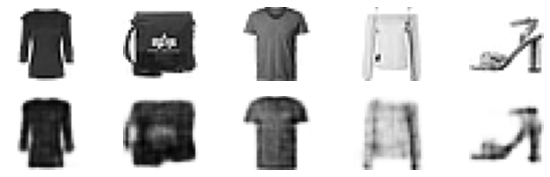

In [51]:
# 합성곱 오토 인코더로 생성한 이미지 출력
show_reconstructions(conv_ae)

## Recurrent Auto Encoder
- 순환 오토 인코더
- Simple ENN, LSTM, GRU층이 있음

- 비지도 학습이나 차원 축소를 위해 
- 시계열이나 텍스트와 같은 시퀀스에 대한 오토 인코더를 만들 땐
- 순환신경망(RNN)이 밀집 네트워크보다 성능이 좋을 수 있음

(1) 인코더
- 입력 시퀀스를 하나의 벡터로 압축하는 시퀀스 투 벡터 RNN을 이용

(2) 디코더
- 벡터 투 시퀀스 RNN을 이용함


In [23]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
# 인코더 생성
recurrent_encoder = keras.models.Sequential([
                                            keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
                                            keras.layers.LSTM(30)
])

In [29]:
# 디코더 생성
# 인코더 생성
recurrent_decoder = keras.models.Sequential([
                                            keras.layers.RepeatVector(28, input_shape=[30]), # 왜 30일까? --> 인코더 마지막 층이 뉴런 30개임
                                            keras.layers.LSTM(100, return_sequences=True),
                                            keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid')                                            )
])

In [ ]:
help(keras.layers.LSTM)

In [46]:
# 합성곱 오토 인코더
# 생성
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

# 컴파일
recurrent_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [47]:
# 훈련
recurrent_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# val_accuracy: 0.0714 - 이미지 쪽에 RNN은 별로 효과가 없음

Epoch 1/5
1719/1719 [==============================] - 101s 56ms/step - loss: 0.5019 - accuracy: 0.0444 - val_loss: 0.4505 - val_accuracy: 0.0477
Epoch 2/5
1719/1719 [==============================] - 94s 55ms/step - loss: 0.4008 - accuracy: 0.0472 - val_loss: 0.3761 - val_accuracy: 0.0538
Epoch 3/5
1719/1719 [==============================] - 94s 55ms/step - loss: 0.3677 - accuracy: 0.0589 - val_loss: 0.3610 - val_accuracy: 0.0664
Epoch 4/5
1719/1719 [==============================] - 93s 54ms/step - loss: 0.3530 - accuracy: 0.0696 - val_loss: 0.3508 - val_accuracy: 0.0703
Epoch 5/5
1719/1719 [==============================] - 92s 54ms/step - loss: 0.3430 - accuracy: 0.0737 - val_loss: 0.3395 - val_accuracy: 0.0714


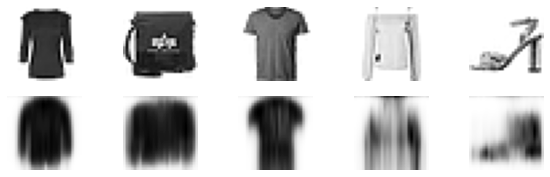

In [59]:
# 순환 오토 인코더로 생성한 이미지 출력
show_reconstructions(recurrent_ae)

## Denoise Auto Encoder
- 잡음 제거 오토인코더
- 입력에 노이즈를 추가하고, 노이즈가 없는 원본 입력을 복원하여 유용한 특성을 학습하도록 강제함

- 이용하는 노이즈
    - 가우시안 노이즈(정규분포)
    - 드롭아웃


#### 가우시안 노이즈 추가

In [52]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [55]:
# 인코더 생성
denoise_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.GaussianNoise(0.2),
                                           keras.layers.Dense(100, activation='selu'),
                                           keras.layers.Dense(30, activation='selu')
])
# Dense층의 기능 : 데이터를 잘게 분할해서 봄 ■■■■■ #!!
# 이 경우는 이미지를 100회 분할하고, 각 조각을 다시 30회 분할함
# 그럼 Dense(100) * Dense(30)은 Dense(3000)과 같을까? --> No!
# Dense(100) * Dense(30)는 30회 쪼갤 때 이미지 영역이 겹쳐 쪼갤 수 있지만
# Dense(3000)는 겹치는 영역이 없을 수 있음
# 둘 다 3000개의 조각이 나오는 것은 맞지만, 각 조각이 다른 데이터를 의미할수 있음
# 그리고 Dense 층을 여러 겹 쓰는 것이 더 효율적인 일처리가 될 수 있음
    ## 사진에 바퀴가 있는가? --> Yes/No 분류하여 Yes에 해당하는 데이터만 재가공하는 스무고개 식으로.. 각 층마다 처리할 데이터 수가 줄어들테니 효율적.

In [56]:
# 디코더 생성
denoise_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                           keras.layers.Dense(28*28, activation='sigmoid'),
                                           keras.layers.Reshape([28, 28])                                                              
])

In [57]:
# 디노이즈 오토 인코더
# 생성
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])

# 컴파일
denoise_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [58]:
# 훈련
denoise_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# 실제로는 1000번 정도 수행하여 acurracy를 높여서 사용함

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4769 - accuracy: 0.0484 - val_loss: 0.3835 - val_accuracy: 0.0558
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3700 - accuracy: 0.0594 - val_loss: 0.3633 - val_accuracy: 0.0611
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3546 - accuracy: 0.0683 - val_loss: 0.3482 - val_accuracy: 0.0751
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3410 - accuracy: 0.0781 - val_loss: 0.3362 - val_accuracy: 0.0798
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3314 - accuracy: 0.0817 - val_loss: 0.3286 - val_accuracy: 0.0832


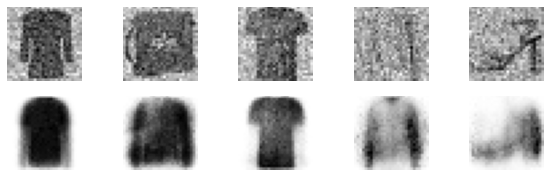

In [62]:
# 디노이즈 오토 인코더로 생성한 이미지 출력
# 우리가 넣어준 노이즈 낀 이미지와 노이즈 제거한 이미지 비교
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoise_ae, noise(X_valid, training=True))

#### 드랍아웃 적용

In [65]:
# 인코더 생성
denoise_encoder2 = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.GaussianNoise(0.2),
                                           keras.layers.Dropout(0.5),    ## 드롭아웃 층 추가
                                           keras.layers.Dense(100, activation='selu'),
                                           keras.layers.Dense(30, activation='selu')
])

In [66]:
# 디코더 생성
denoise_decoder2 = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                           keras.layers.Dense(28*28, activation='sigmoid'),
                                           keras.layers.Reshape([28, 28])                                                              
])

In [68]:
# 생성
denoise_ae2 = keras.models.Sequential([denoise_encoder2, denoise_decoder2])

# 컴파일
denoise_ae2.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [69]:
# 훈련
history = denoise_ae2.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# val_accuracy: 0.0810

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4895 - accuracy: 0.0459 - val_loss: 0.4024 - val_accuracy: 0.0527
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3778 - accuracy: 0.0596 - val_loss: 0.3631 - val_accuracy: 0.0645
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3583 - accuracy: 0.0685 - val_loss: 0.3483 - val_accuracy: 0.0753
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3478 - accuracy: 0.0755 - val_loss: 0.3401 - val_accuracy: 0.0775
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3407 - accuracy: 0.0785 - val_loss: 0.3331 - val_accuracy: 0.0810


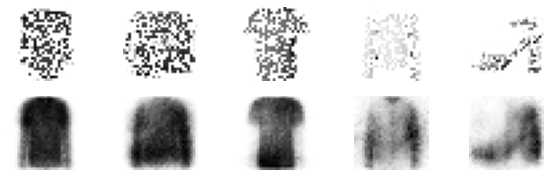

In [71]:
# 디노이즈 오토 인코더로 생성한 이미지 출력
# 우리가 넣어준 드롭아웃 적용한 이미지와 처리한 이미지 비교
dropout = keras.layers.Dropout(0.5)
show_reconstructions(denoise_ae2, dropout(X_valid, training=True))

## Sparse Auto Encoder
- 희소 오토 인코더
- 비용함수에 적절한 항을 추가해서 코딩 층에서 활성화되는 **뉴런 수를 감소**시켜 만드는 방법
    - 당연히 성능은 떨어짐
- 시그모이드 활성화 함수를 사용하고, 코딩 층의 활성화 값에 L1 규제를 추가함
    - L1 : Lasso - 미분 반복하여 0이 되는 때도 있음
    - L2 : Ridge - 영향력을 줄이기만 함
    - ElasticNet : L1, L2의 혼합

(1) 인코더
- ActivityRegularzation 층을 추가하여 L1 값을 설정
- 일반적으로 작은 값을 사용함. 0.001 정도

In [82]:
# 인코더 생성
sparse_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='sigmoid'),  # 마지막 층이 sigmoid면 됨
                                          keras.layers.ActivityRegularization(l1=1e-3)  # 0.001 # 인코더 마지막 층에 L1 규제를 적용함
])

In [83]:
# 디코더 생성
sparse_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(28*28, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])                                                              
])

In [84]:
# 생성
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])

# 컴파일
sparse_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [85]:
# 훈련
history = sparse_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# val_accuracy: 0.0556

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5556 - accuracy: 0.0442 - val_loss: 0.5055 - val_accuracy: 0.0452
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4946 - accuracy: 0.0472 - val_loss: 0.4861 - val_accuracy: 0.0479
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4669 - accuracy: 0.0490 - val_loss: 0.4490 - val_accuracy: 0.0470
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4281 - accuracy: 0.0512 - val_loss: 0.4157 - val_accuracy: 0.0519
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4037 - accuracy: 0.0558 - val_loss: 0.3989 - val_accuracy: 0.0556


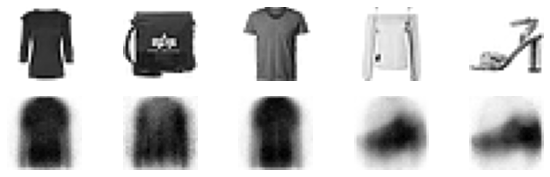

In [86]:
# 디노이즈 오토 인코더로 생성한 이미지 출력
# 우리가 넣어준 드롭아웃 적용한 이미지와 처리한 이미지 비교
l1regular = keras.layers.ActivityRegularization(l1=0.001)
show_reconstructions(sparse_ae, l1regular(X_valid, training=True))

* selu, sigmoid의 차이
* selu

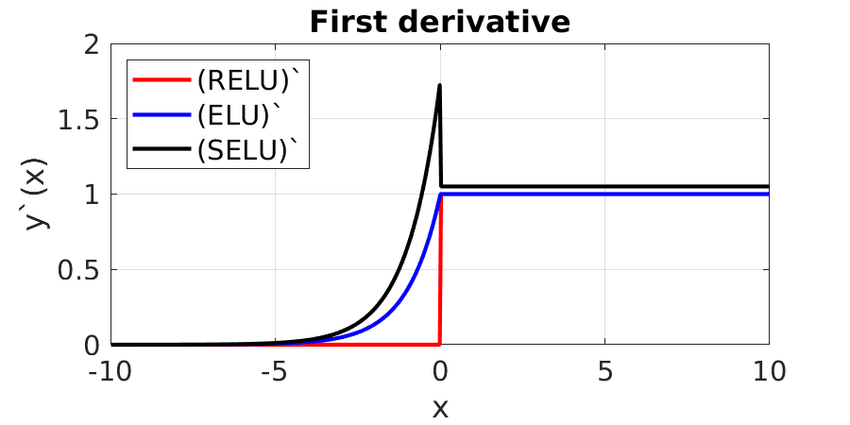
* sigmoid
    * http://taewan.kim/post/sigmoid_diff/
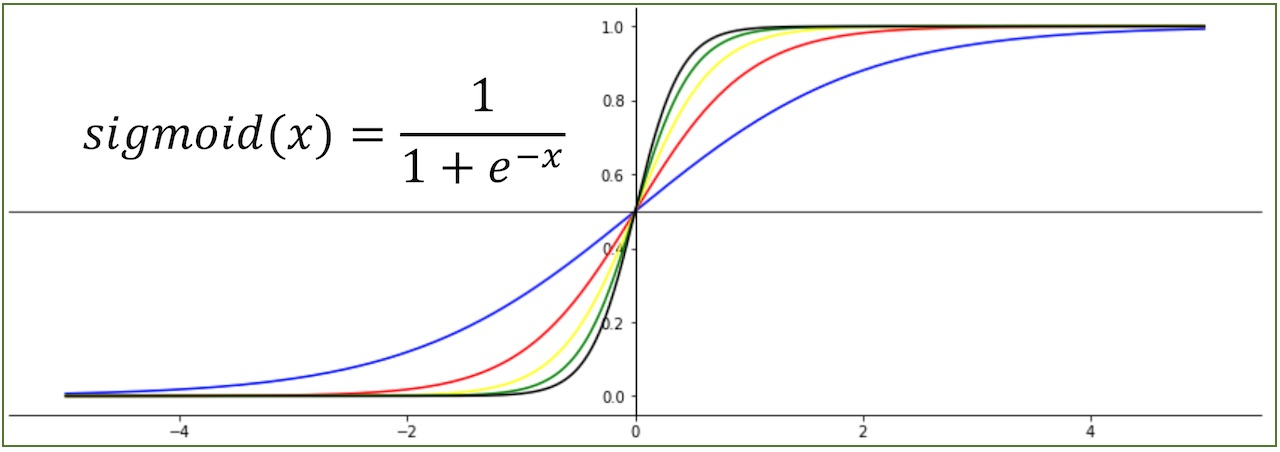

## VAE
- Variatioanl Auto Encoder
- 특징
    - 변이 오토 인코더
        - 생성 모델링에서 가장 기본적이고 널리 알려진 딥러닝 구조 중 하나
    - 확률에 기반함. 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨.
        - 다른 오토 인코더 : 훈련할 때만 우연이 적용됨
    - 생성 오토 인코더
    	- 훈련 세트에서 샘플링 된 것 같은 새로운 샘플을 만들 수 있음

- 구동 원리
    - 인코더 : 평균, 표준편차를 생성
    - 실제 코딩을 만들 때 : 생성한 평균, 표준편차로 가우시안 분포를 만들고 샘플링
    - 디코더 : 출력
        - 가우시안 잡음이 추가됨

- VAE 생성 방법
    - keras.layers.layer로부터 클래스를 상속받아 __call__ 메소드를 재정의함
    - inputs의 평균, 표준편차를 받아서 정규분포를 만들고
    - 하나의 데이터를 리턴하도록 함

### 샘플링을 위한 클래스 만들기
- 패션 MNIST에 VAE 적용

In [88]:
# 케라스의 레이어 클래스를 상속 받아서 VAE 구현하기
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        # 평균과 표준편차 가져오기
        mean, log_var = inputs
        # K.random_normal : 정규분포 생성
        # 지수함수(K.exp)를 곱하고 평균을 더함
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean